#### Overview


This is Rob's notebook for experimenting with DAS data without muddling up some other notebook. 


- `pip install minio` worked; opened jupyter-lab, started this nbk
    - [minio API documentation](https://min.io/docs/minio/linux/developers/python/API.html)
- placed credentials outside the repo; reads them; instantiate a minio `client`
- list: `buckets = client.list_buckets()`. These include the source HDF5 bucket `OOI-DAS-HDF5`
- list object_name for objects in this bucket; download the first one
    - Ten files, contiguous time: 02-NOV-2021, Time 00:00:14, 01:14 etc in one-minute intervals
    - One file: 200 Hz, one minute, 12,000 pulses; 47,500 channels per pulse (5 meters?)
- open the file using `xarray.open_dataset()`
    - this is challenging owing to the intrinsic heirarchy of the datafile
    - a useful tool to know about is [datatree](https://github.com/xarray-contrib/datatree)
    - the idea is that within the file is a folder structure; but using the term 'groups'
    - 

In [30]:
from minio import Minio

with open('./../../.minio/k.txt', 'r') as file:
    keys = file.read().split(' ')

client = Minio("pnwstore1.ess.washington.edu:9000", keys[0], keys[1], secure=False)

`buckets = client.list_buckets()`

```
 Bucket('OOI-DAS-1-Zarr'), etcetera 1, 2, 3, 4, 5, 10, 50, 100, 500, 1000
 Bucket('OOI-DAS-1-tileDB'), etcetera 1, 2, 3, 4, 5
 Bucket('OOI-DAS-HDF5'),
 Bucket('OOI-DAS-HDF5-Zarr')
 ```

In [36]:
source = buckets[15]
type(source)

minio.datatypes.Bucket

In [45]:
# List objects information.
objects = client.list_objects("OOI-DAS-HDF5")
for obj in objects:
    if obj.object_name[0] == '2':
        print(obj.object_name, obj.size) 

2021-11-02T000014Z.h5 1204819290
2021-11-02T000114Z.h5 1204792796
2021-11-02T000214Z.h5 1203327766
2021-11-02T000314Z.h5 1203341437
2021-11-02T000414Z.h5 1202527684
2021-11-02T000514Z.h5 1202630049
2021-11-02T000614Z.h5 1204170375
2021-11-02T000714Z.h5 1202733980
2021-11-02T000814Z.h5 1203993665
2021-11-02T000914Z.h5 1204293626


In [51]:
objects = client.list_objects("OOI-DAS-HDF5")
for obj in objects:
    print(obj.object_name)
    if obj.object_name[0] == '2':
        this_object_name = obj.object_name
        print('getting: ', this_object_name, obj.size)
        client.fget_object("OOI-DAS-HDF5", this_object_name, "../../data/das/" + this_object_name, request_headers=None, ssec=None, version_id=None, extra_query_params=None, tmp_file_path=None)
        break

.zgroup
2021-11-02T000014Z.h5
getting:  2021-11-02T000014Z.h5 1204819290


In [40]:
obj.object_name

'2021-11-02T000914Z.h5'

In [81]:
import xarray as xr
ds = xr.open_dataset('./../../data/das/' + obj.object_name, group='Acquisition/Raw[0]')
ds

<xarray.Dataset>
Dimensions:      (phony_dim_1: 47500, phony_dim_2: 12000)
Dimensions without coordinates: phony_dim_1, phony_dim_2
Data variables:
    RawData      (phony_dim_1, phony_dim_2) int32 ...
    RawDataTime  (phony_dim_2) int64 ...
Attributes:
    uuid:             286dc853-a001-4ec8-982b-3a18ccfaf5e3
    NumberOfLoci:     47500
    StartLocusIndex:  0
    OutputDataRate:   200.0
    RawDataUnit:      rad * 2PI/2^16
    RawDescription:   Diversity Processed Phase Dual Pulse Balanced. Ocp 20

In [166]:
ds.RawData[0:10].values

array([[15060531, 15058930, 15059663, ..., 14779586, 14779737, 14780104],
       [ 6796435,  6794743,  6795224, ...,  7058146,  7057697,  7057752],
       [ 4664684,  4659857,  4654133, ...,  3762495,  3759299,  3758024],
       ...,
       [ 6901692,  6898821,  6898423, ...,  6655416,  6655720,  6655557],
       [ 7470141,  7467206,  7466590, ...,  7238198,  7238669,  7238328],
       [ 8196864,  8193923,  8193292, ...,  8023220,  8023816,  8023170]],
      dtype=int32)

In [167]:
import netCDF4
ncf = netCDF4.Dataset('./../../data/das/' + obj.object_name)
ncf.groups

{'Acquisition': <class 'netCDF4._netCDF4.Group'>
 group /Acquisition:
     schemaVersion: 2.0
     uuid: 55e16fd1-ecc9-49d6-962a-ab72c3f3b030
     AcquisitionId: 55e16fd1-ecc9-49d6-962a-ab72c3f3b030
     NumberOfLoci: 47500
     StartLocusIndex: 0
     SpatialSamplingInterval: 2.0419047
     TriggeredMeasurement: false
     SpatialSamplingIntervalUnit: m
     GaugeLength: 51.04762
     GaugeLengthUnit: m
     MinimumFrequency: 0.0
     MaximumFrequency: 100.0
     PulseRate: 1000.0
     PulseWidth: 250.0
     PulseWidthUnit: ns
     VendorCode: OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46
     dimensions(sizes): 
     variables(dimensions): 
     groups: Custom, Raw[0]}

In [168]:
ds.info()

xarray.Dataset {
dimensions:
	phony_dim_1 = 47500 ;
	phony_dim_2 = 12000 ;

variables:
	int32 RawData(phony_dim_1, phony_dim_2) ;
		RawData:Dimensions = ['locus', 'time'] ;
		RawData:Count = 570000000 ;
		RawData:StartIndex = 612000 ;
		RawData:PartStartTime = 2021-11-02T00:00:14.834000Z ;
		RawData:PartEndTime = 2021-11-02T00:01:14.829000Z ;
	int64 RawDataTime(phony_dim_2) ;
		RawDataTime:Count = 12000 ;
		RawDataTime:StartIndex = 612000 ;
		RawDataTime:StartTime = 2021-11-01T23:09:14.834000Z ;
		RawDataTime:PartStartTime = 2021-11-02T00:00:14.834000Z ;
		RawDataTime:PartEndTime = 2021-11-02T00:01:14.829000Z ;

// global attributes:
	:uuid = 286dc853-a001-4ec8-982b-3a18ccfaf5e3 ;
	:NumberOfLoci = 47500 ;
	:StartLocusIndex = 0 ;
	:OutputDataRate = 200.0 ;
	:RawDataUnit = rad * 2PI/2^16 ;
	:RawDescription = Diversity Processed Phase Dual Pulse Balanced. Ocp 20 ;
}

In [169]:
obj.object_name

'2021-11-02T000014Z.h5'

In [73]:
!ncdump --help

ncdump: invalid option -- '-'
ncdump [-c|-h] [-v ...] [[-b|-f] [c|f]] [-l len] [-n name] [-p n[,n]] [-k] [-x] [-s] [-t|-i] [-g ...] [-w] [-Ln] file
  [-c]             Coordinate variable data and header information
  [-h]             Header information only, no data
  [-v var1[,...]]  Data for variable(s) <var1>,... only
  [-b [c|f]]       Brief annotations for C or Fortran indices in data
  [-f [c|f]]       Full annotations for C or Fortran indices in data
  [-l len]         Line length maximum in data section (default 80)
  [-n name]        Name for netCDF (default derived from file name)
  [-p n[,n]]       Display floating-point values with less precision
  [-k]             Output kind of netCDF file
  [-s]             Output special (virtual) attributes
  [-t]             Output time data as date-time strings
  [-i]             Output time data as date-time strings with ISO-8601 'T' separator
  [-g grp1[,...]]  Data and metadata for group(s) <grp1>,... only
  [-w]             With 

In [74]:
!ncdump -h ./../../data/das/2021-11-02T000014Z.h5

netcdf \2021-11-02T000014Z {

// global attributes:
		:uuid = "a587ea7c-a1f4-4277-b097-57ec66c3d1e5" ;

group: Acquisition {

  // group attributes:
  		:schemaVersion = "2.0" ;
  		:uuid = "55e16fd1-ecc9-49d6-962a-ab72c3f3b030" ;
  		:AcquisitionId = "55e16fd1-ecc9-49d6-962a-ab72c3f3b030" ;
  		:NumberOfLoci = 47500 ;
  		:StartLocusIndex = 0 ;
  		:SpatialSamplingInterval = 2.041905f ;
  		:TriggeredMeasurement = "false" ;
  		:SpatialSamplingIntervalUnit = "m" ;
  		:GaugeLength = 51.04762f ;
  		:GaugeLengthUnit = "m" ;
  		:MinimumFrequency = 0.f ;
  		:MaximumFrequency = 100.f ;
  		:PulseRate = 1000.f ;
  		:PulseWidth = 250.f ;
  		:PulseWidthUnit = "ns" ;
  		:VendorCode = "OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46" ;

  group: Custom {

    // group attributes:
    		:CustomSchemaVersion = 3 ;
    		:Laser\ Wavelength\ \(nm\) = 1550 ;
    		:Fibre\ Refractive\ Index = 1.4682f ;
    		:GPS\ Sync\ Guaranteed = 1b ;
    		:CSU\ Resolution\ \(ns\) = 1 ;
  

In [170]:
ds

<xarray.Dataset>
Dimensions:      (phony_dim_1: 47500, phony_dim_2: 12000)
Dimensions without coordinates: phony_dim_1, phony_dim_2
Data variables:
    RawData      (phony_dim_1, phony_dim_2) int32 ...
    RawDataTime  (phony_dim_2) int64 1635811214834000 ... 1635811274829000
Attributes:
    uuid:             286dc853-a001-4ec8-982b-3a18ccfaf5e3
    NumberOfLoci:     47500
    StartLocusIndex:  0
    OutputDataRate:   200.0
    RawDataUnit:      rad * 2PI/2^16
    RawDescription:   Diversity Processed Phase Dual Pulse Balanced. Ocp 20

<class 'numpy.ndarray'>
6000
<class 'numpy.ndarray'>
6000


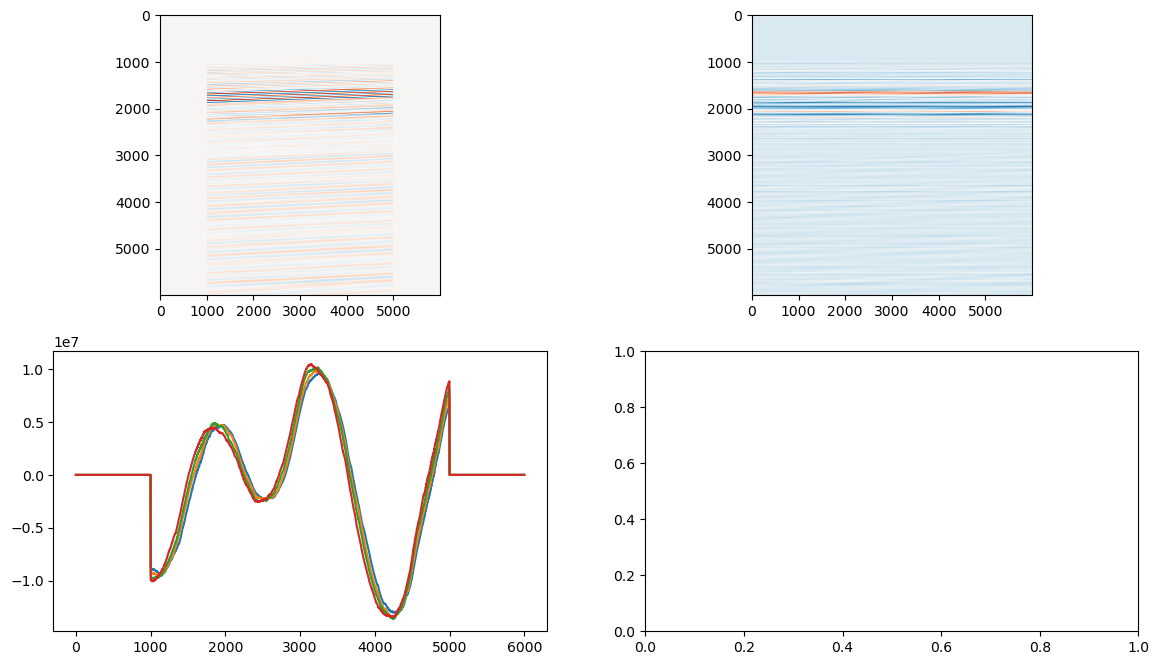

In [236]:
wid=6000
a=ds.RawData[0:wid,0:wid].values
f=np.zeros((wid,wid))

a.size
print(type(a))
print(len(a))
print(type(a[0]))
print(len(a[0]))           # these are int32 values

fhwid, k = 1000, []
for i in range(1, fhwid+1): k.append(i)
for i in range(fhwid - 1, 0, -1): k.append(i)
ksum = sum(k)
k = [k[i]/ksum for i in range(len(k))]

fwid = len(k)

for i in range(wid):
    b = a[i][:]                # ndarray of wid int32 elements
    c = np.convolve(b, k)
    d = c[fhwid:wid+fhwid]
    d[0:fhwid]=b[0:fhwid]
    d[wid - 1 - fhwid:wid]=b[wid - 1 - fhwid:wid]
    e = b-d
    f[i] = e[:]
    
fig,ax=plt.subplots(2,2,figsize=(14,8))
ax[0][0].imshow(f, cmap='RdBu')
ax[0][1].imshow(a, cmap='RdBu')
ax[1][0].plot(f[1600])
ax[1][0].plot(f[1601])
ax[1][0].plot(f[1602])
ax[1][0].plot(f[1603])

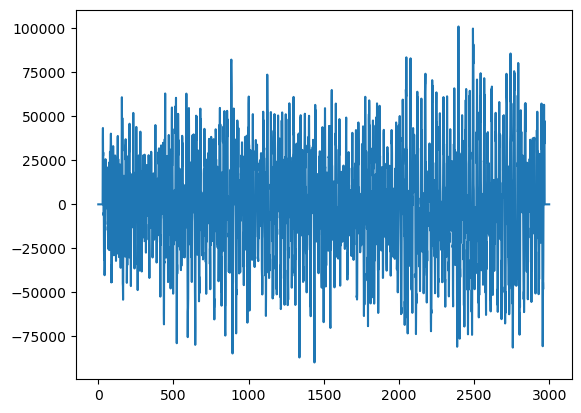

In [221]:
    
fig,ax=plt.subplots()
# ax.plot(b[wid-200:wid])
ax.plot(e)
fig.show()

In [195]:
len(c)

3024

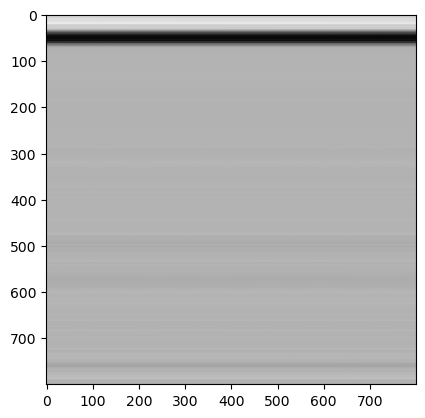

In [113]:
from matplotlib import pyplot as plt
fig,ax=plt.subplots()
ax.imshow(a, cmap='gray')

4000000

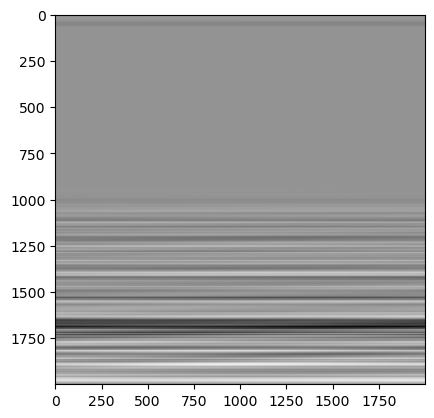

In [120]:
fig,ax=plt.subplots()
ax.imshow(a, cmap='gray')

In [143]:
a=ds.RawData[0:wid,0:wid].values
print(np.mean(a), np.std(a))
print(np.mean(a[0]), np.std(a[0]))
print(np.mean(a[1]), np.std(a[1]))
print(np.mean(a[1998]), np.std(a[1998]))
print(np.mean(a[1999]), np.std(a[1999]))

1210927.233731 56542560.87067221
14925703.415 55522.6627443585
6777299.0905 45656.65222061633
26364870.6735 10242412.027349293
34581675.5645 10322153.03162381


In [132]:
for i in range(wid):
    m = np.mean(a[i])
    b = [a[i][j] - m for j in range(wid)]
    a[i][:] = b

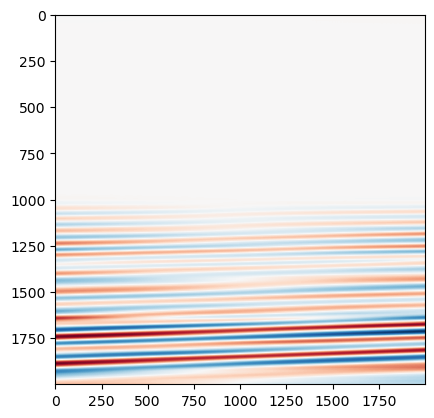

In [133]:
fig,ax=plt.subplots()
ax.imshow(a, cmap='RdBu')

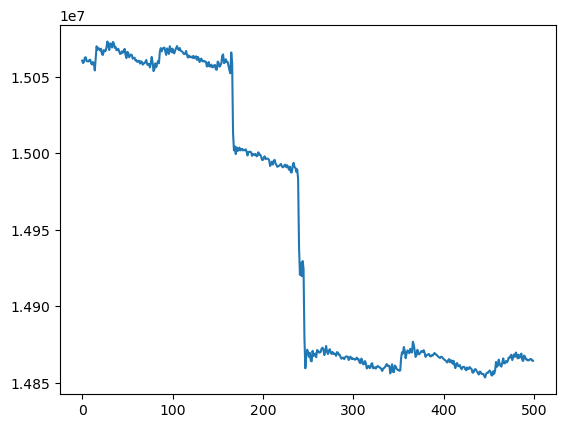

In [147]:
fig,ax=plt.subplots()
ax.plot(a[0][0:500])
fig.show()

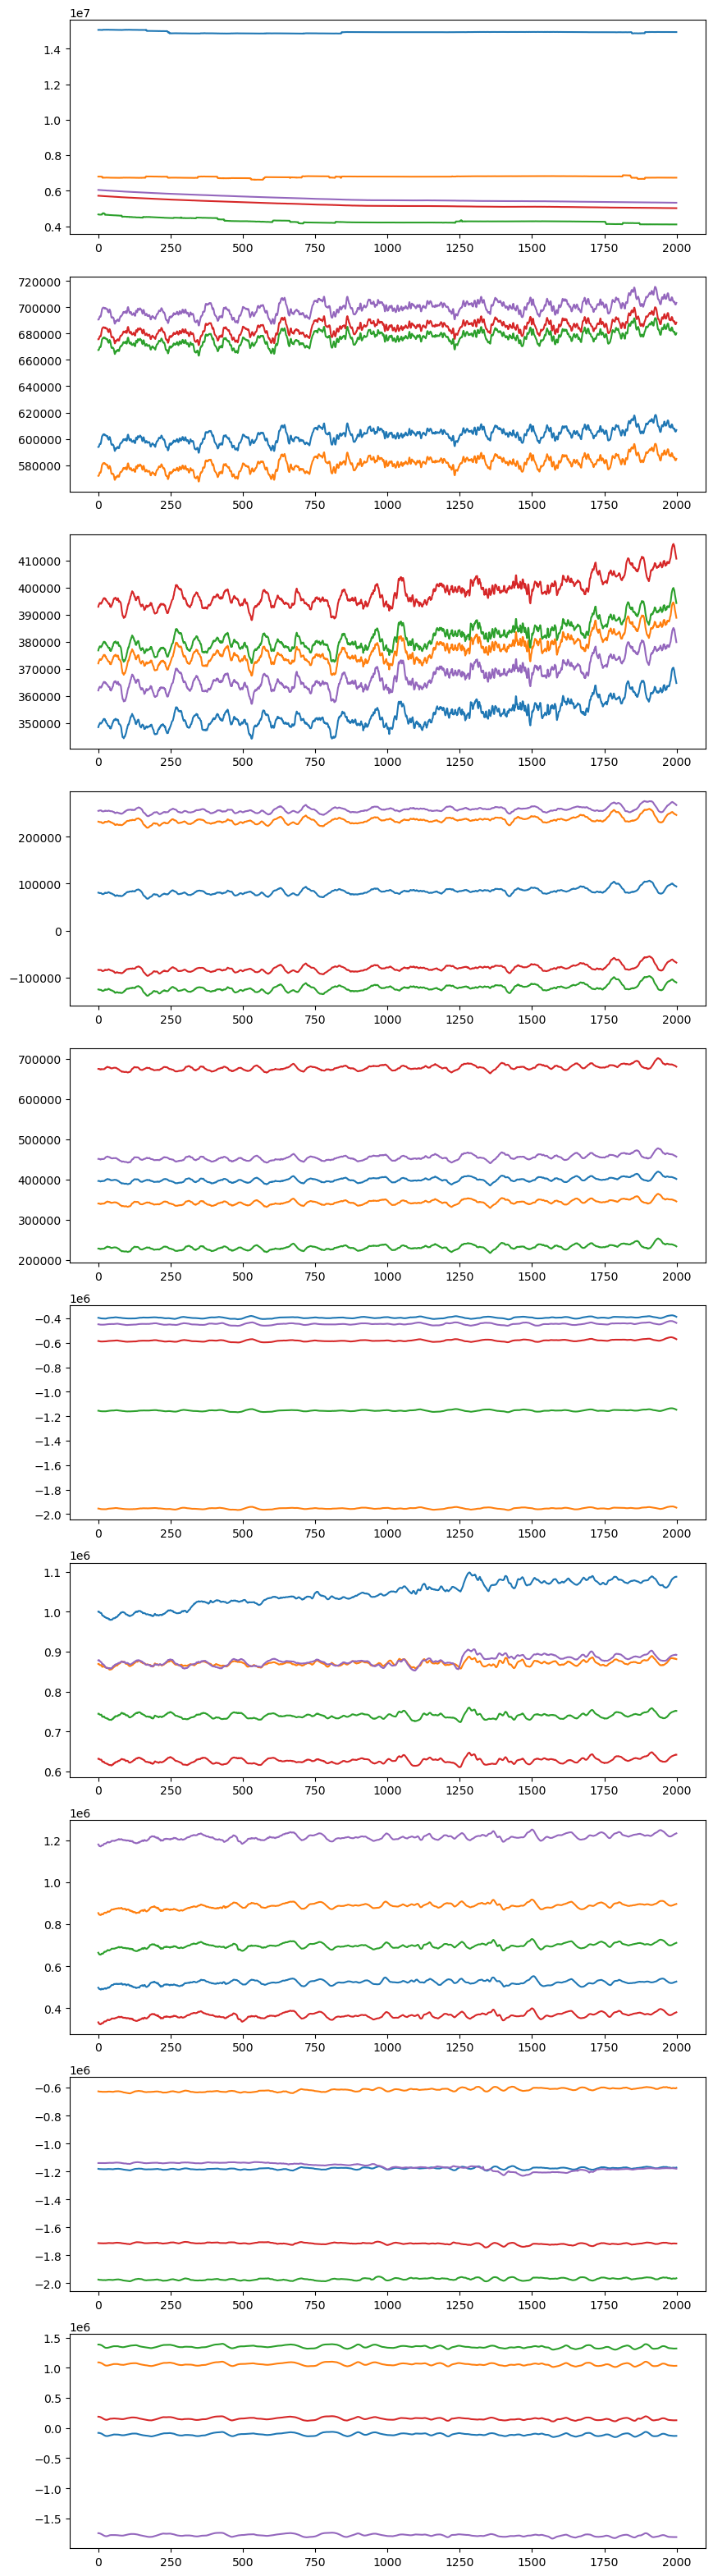

In [165]:
fig,ax=plt.subplots(10, figsize=(10,40))
for n in range(10):
    for i in range(n*100, n*100 + 5):
        ax[n].plot(a[i])
fig.show()